<a href="https://colab.research.google.com/github/jumbokh/python_learn/blob/master/notebooks/04_%E4%BD%BF%E7%94%A8Darknet_MQTT_ESP32CAM%E9%80%B2%E8%A1%8C%E8%BE%A8%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4v7物件辨識演算法，使用ESP32CAM的MQTT
# 縮網址：https://twgo.io/trlis

請先複製到自己的雲端硬碟

當Darknet網路建立完畢，後續就可以直接使用

步驟1：連結到自己的雲端硬碟，後續可以直接啟用辨識

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


步驟2：將路徑移動到自己的雲端硬碟

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/darknet

/content/drive/MyDrive/Colab Notebooks/darknet


步驟3：載入相依性套件

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Darknet for Python
步驟4：載入Darknet

這部份為使用Darknet所需要的一些功能，其中第2行所載入的路徑，必須要注意
包含三個設定：cfg網路設定檔，data能辨識的物件名稱，weights類神經網路權重檔

In [ ]:
#選擇你要用的網路型態
YOLO_cfg='cfg/yolov7.cfg' # cfg/yolov4-tiny.cfg
YOLO_weight='yolov7.weights' # yolov4.weights
YOLO_label='cfg/coco.data'


步驟5：載入神經網路

建立darknet_dect副程式

In [ ]:
from darknet import *
network, class_names, class_colors = load_network(YOLO_cfg, YOLO_label, YOLO_weight)
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_dect(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## 測試
步驟6：先使用內建的照片進行測試，內建的照片都放在data中，可以用雲端硬碟來事先查看

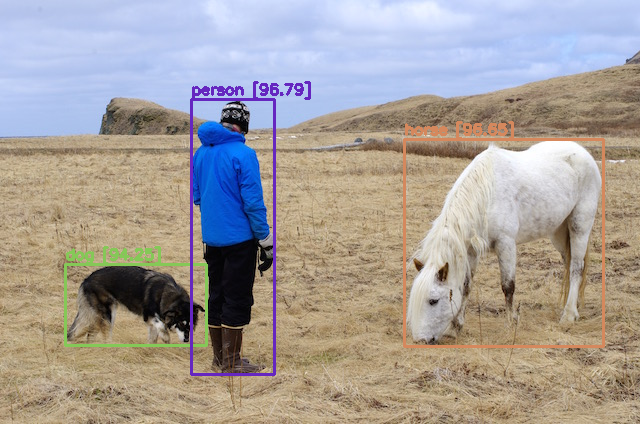

In [ ]:
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_dect(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)

cv2_imshow(image)

步驟7：

安裝MQTT套件

並指定MQTT主題

指定照片存檔位置(須自行在雲端硬碟中建立資料夾)

In [ ]:
!pip install paho-mqtt
pic_topic="艾瑞克/電腦A/即時影像"
SavePath='esp32cam' #請自行先在Colab Notebooks中建立資料夾

步驟8：開始Darknet及MQTT辨識

In [ ]:
from datetime import datetime
import paho.mqtt.client as paho

broker="mqttgo.io"

#接收MQTT
def on_message(client, userdata, message):
  print("Receiving message")
  print(message.topic)
    #讀取MQTT的照片
  if (message.topic == pic_topic):
    #儲存檔案
    fileName=datetime.utcnow().strftime('%Y%m%d %H%M%S.%f')[:-3]
    filePath='/content/drive/MyDrive/Colab Notebooks/' + SavePath + '/' + str(fileName) + '.jpg'
    img = cv2.imread(filePath)
    f=open(filePath, "wb")
    f.write(message.payload)
    f.close()
    img = cv2.imread(filePath)
    #進行辨識
    detections, width_ratio, height_ratio = darknet_dect(img, width, height)
    #darknet_dect(img, width, height)
    objCount ={ }
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox) #比例
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
      cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
      #      照片    文字內容                     位置         字形          大小   顏色      寬度
      cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
      #利用python字典將所有的detections的label列舉出現次數
      if label in objCount.keys():
        objCount[label] = objCount[label] + 1
      else:
        objCount[label] = 1
    print(objCount)
    cv2_imshow(img)
    cv2.imwrite(filePath,img)


print("Starting")
client=paho.Client("")
client.connect(broker)
client.subscribe(pic_topic)
client.on_message = on_message
client.loop_forever()

#辨識後將人數統計送回MQTT儀表板

步驟九：
設定人數的Topic名稱

In [ ]:
personCountTopic='艾瑞克/電腦A/人數'

In [ ]:
from datetime import datetime
import paho.mqtt.client as paho

broker="mqttgo.io"

#接收MQTT
def on_message(client, userdata, message):
  print("Receiving message")
  print(message.topic)
    #讀取MQTT的照片
  if (message.topic == pic_topic):
    #儲存檔案
    fileName=datetime.utcnow().strftime('%Y%m%d %H%M%S.%f')[:-3]
    filePath='/content/drive/MyDrive/Colab Notebooks/' + SavePath + '/' + str(fileName) + '.jpg'
    img = cv2.imread(filePath)
    f=open(filePath, "wb")
    f.write(message.payload)
    f.close()
    img = cv2.imread(filePath)
    #進行辨識
    detections, width_ratio, height_ratio = darknet_dect(img, width, height)
    #darknet_dect(img, width, height)
    objCount ={ }
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox) #比例
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
      cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
      #      照片    文字內容                     位置         字形          大小   顏色      寬度
      cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
      #利用python字典將所有的detections的label列舉出現次數
      if label in objCount.keys():
        objCount[label] = objCount[label] + 1
      else:
        objCount[label] = 1
    print(objCount)
    cv2_imshow(img)
    if 'person' in objCount.keys():
      if objCount['person']>=1:
        result = client.publish(personCountTopic,str(objCount['person']))
        print('result=',result)
    else:
      result = client.publish(personCountTopic, '0')


print("Starting")
client=paho.Client("")
client.connect(broker)
client.subscribe(pic_topic)
client.on_message = on_message
client.loop_forever()